In [ ]:
import tensorflow as tf
from skimage import io
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import Model
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import cv2 as cv
from skimage import feature as skif

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chargement des données

In [ ]:
X_train = np.load("/content/drive/MyDrive/Dataset/anti_spoofing/only_tf/features_tf_train.npy")
y_train = np.load("/content/drive/MyDrive/Dataset/anti_spoofing/only_tf/labels_tf_train.npy")
X_test = np.load("/content/drive/MyDrive/Dataset/anti_spoofing/only_tf/features_tf_test.npy")
y_test = np.load("/content/drive/MyDrive/Dataset/anti_spoofing/only_tf/labels_tf_test.npy")

# Implémentation des models

## Courbes d'apprentissage

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Réduction des dimentions

In [ ]:
X_train[0].shape

(256,)

In [ ]:
# Calcul des composantes principales
n_comp_init = X_train[0].shape[0]
pca = decomposition.PCA(n_components=n_comp_init)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

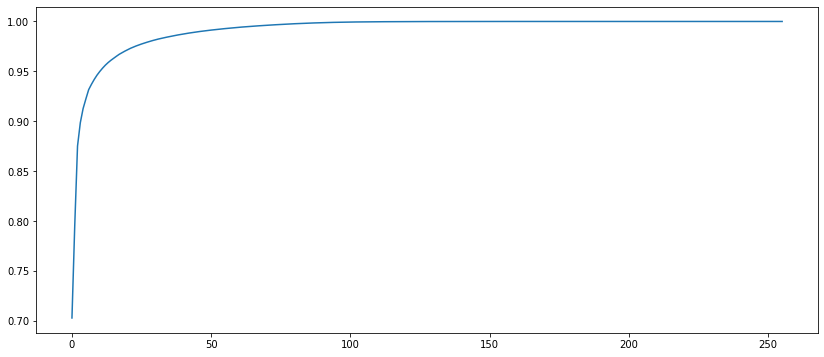

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
axes.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
total = 0
i = 29
for j in range(i):
  total += pca.explained_variance_ratio_[j]

print('{} demnsions expliquent {}% de données'.format(i, total))

29 demnsions expliquent 0.9801001846542164% de données


In [ ]:
n_comp = 29
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
filename = '/content/drive/MyDrive/Dataset/anti_spoofing/models/tf_pca.sav'
pickle.dump(pca, open(filename, 'wb'))

## Model SVM

In [ ]:
model_svm = make_pipeline(StandardScaler(), SVC())

params = {'svc__kernel': ['rbf', 'linear'],
         'svc__C': [1e3, 1, 0.5]}

grid = GridSearchCV(model_svm, params, cv=5)

print(grid)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            t

In [ ]:
# Formation du model
grid.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            t

In [ ]:
# Meilleurs paramètres
grid.best_params_

{'svc__C': 1, 'svc__kernel': 'rbf'}

In [ ]:
# Score sur les données d'entrainement
grid.score(X_train_pca, y_train)

0.9321666666666667

In [ ]:
# Score sur les données de test
grid.score(X_test_pca, y_test)

0.8505

In [ ]:
# Résultat obtenus
print(classification_report(y_test, grid.predict(X_test_pca), target_names=['Live', 'Spoof']))

              precision    recall  f1-score   support

        Live       0.82      0.89      0.86      1000
       Spoof       0.88      0.81      0.84      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [ ]:
# Matrice de confusion sur les données de test
confusion = confusion_matrix(y_test, grid.predict(X_test_pca))
confusion

array([[890, 110],
       [189, 811]])

In [ ]:
model_svm = grid.best_estimator_
filename = '/content/drive/MyDrive/Dataset/anti_spoofing/models/tf_svm.sav'
pickle.dump(model_svm, open(filename, 'wb'))

## Logistic regression

In [ ]:
model_lr = make_pipeline(StandardScaler(), LogisticRegression())

params = {'logisticregression__C': [0.5, 1, 1e3]}

grid_lr = GridSearchCV(model_lr, params, cv=5)

print(grid_lr)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

In [ ]:
# Formation du model
grid_lr.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

In [ ]:
# Meilleurs paramètres
grid_lr.best_params_

{'logisticregression__C': 1000.0}

In [ ]:
# Score sur les données d'entrainement
grid_lr.score(X_train_pca, y_train)

0.8998333333333334

In [ ]:
# Score sur les données de test
grid_lr.score(X_test_pca, y_test)

0.856

In [ ]:
# Résultat obtenus
print(classification_report(y_test, grid_lr.predict(X_test_pca), target_names=['Live', 'Spoof']))

              precision    recall  f1-score   support

        Live       0.84      0.88      0.86      1000
       Spoof       0.88      0.83      0.85      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [ ]:
# Matrice de confusion sur les données de test
confusion = confusion_matrix(y_test, grid_lr.predict(X_test_pca))
confusion

array([[884, 116],
       [172, 828]])

In [ ]:
model_lr = grid_lr.best_estimator_
filename = '/content/drive/MyDrive/Dataset/anti_spoofing/models/tf_lr.sav'
pickle.dump(model_lr, open(filename, 'wb'))

## Random Forest

In [ ]:
model_rf = make_pipeline(StandardScaler(), RandomForestClassifier())

params = {}

grid_rf = GridSearchCV(model_rf, params, cv=5)

print(grid_rf)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [ ]:
# Formation du model
grid_rf.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [ ]:
# Meilleurs paramètres
grid_rf.best_params_

{}

In [ ]:
# Score sur les données d'entrainement
grid_rf.score(X_train_pca, y_train)

1.0

In [ ]:
# Score sur les données de test
grid_rf.score(X_test_pca, y_test)

0.855

In [ ]:
# Résultat obtenus
print(classification_report(y_test, grid_rf.predict(X_test_pca), target_names=['Live', 'Spoof']))

              precision    recall  f1-score   support

        Live       0.82      0.90      0.86      1000
       Spoof       0.89      0.81      0.85      1000

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [ ]:
# Matrice de confusion sur les données de test
confusion = confusion_matrix(y_test, grid_rf.predict(X_test_pca))
confusion

array([[903,  97],
       [193, 807]])

In [ ]:
model_rf = grid_rf.best_estimator_
filename = '/content/drive/MyDrive/Dataset/anti_spoofing/models/tf_rf.sav'
pickle.dump(model_rf, open(filename, 'wb'))

## Decision Tree

In [ ]:
model_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())

params = {}

grid_dt = GridSearchCV(model_dt, params, cv=5)

print(grid_dt)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
          

In [ ]:
# Formation du model
grid_dt.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
          

In [ ]:
# Meilleurs paramètres
grid_dt.best_params_

{}

In [ ]:
# Score sur les données d'entrainement
grid_dt.score(X_train_pca, y_train)

1.0

In [ ]:
# Score sur les données de test
grid_dt.score(X_test_pca, y_test)

0.79

In [ ]:
# Résultat obtenus
print(classification_report(y_test, grid_dt.predict(X_test_pca), target_names=['Live', 'Spoof']))

              precision    recall  f1-score   support

        Live       0.77      0.83      0.80      1000
       Spoof       0.81      0.75      0.78      1000

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [ ]:
# Matrice de confusion sur les données de test
confusion = confusion_matrix(y_test, grid_dt.predict(X_test_pca))
confusion

array([[828, 172],
       [248, 752]])

In [ ]:
model_dt = grid_dt.best_estimator_
filename = '/content/drive/MyDrive/Dataset/anti_spoofing/models/tf_dt.sav'
pickle.dump(model_dt, open(filename, 'wb'))

## Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

model_sgd = make_pipeline(StandardScaler(), SGDClassifier())

params = {}

grid_sgd = GridSearchCV(model_sgd, params, cv=5)

print(grid_sgd)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('sgdclassifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
          

In [ ]:
# Formation du model
grid_sgd.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('sgdclassifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
          

In [ ]:
# Score sur les données d'entrainement
grid_sgd.score(X_train_pca, y_train)

0.8921666666666667

In [ ]:
# Score sur les données de test
grid_sgd.score(X_test_pca, y_test)

0.8545

In [ ]:
# Résultat obtenus
print(classification_report(y_test, grid_sgd.predict(X_test_pca), target_names=['Live', 'Spoof']))

              precision    recall  f1-score   support

        Live       0.85      0.86      0.86      1000
       Spoof       0.86      0.85      0.85      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [ ]:
# Matrice de confusion sur les données de test
confusion = confusion_matrix(y_test, grid_sgd.predict(X_test_pca))
confusion

array([[861, 139],
       [152, 848]])

In [ ]:
model_sgd = grid_sgd.best_estimator_
filename = '/content/drive/MyDrive/Dataset/anti_spoofing/models/tf_sgd.sav'
pickle.dump(model_sgd, open(filename, 'wb'))

## Neural network

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(n_comp)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7680      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 48,897
Trainable params: 48,897
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_pca, y_train, batch_size=32, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
150/150 [==============================] - 2s 5ms/step - loss: 0.3230 - accuracy: 0.8683 - val_loss: 0.2396 - val_accuracy: 0.9025
Epoch 2/30
150/150 [==============================] - 0s 3ms/step - loss: 0.2419 - accuracy: 0.9029 - val_loss: 0.2376 - val_accuracy: 0.9042
Epoch 3/30
150/150 [==============================] - 0s 3ms/step - loss: 0.2508 - accuracy: 0.8985 - val_loss: 0.2342 - val_accuracy: 0.9075
Epoch 4/30
150/150 [==============================] - 0s 3ms/step - loss: 0.2419 - accuracy: 0.9076 - val_loss: 0.2286 - val_accuracy: 0.9025
Epoch 5/30
150/150 [==============================] - 0s 3ms/step - loss: 0.2450 - accuracy: 0.8969 - val_loss: 0.2233 - val_accuracy: 0.9017
Epoch 6/30
150/150 [==============================] - 0s 3ms/step - loss: 0.2215 - accuracy: 0.9109 - val_loss: 0.2224 - val_accuracy: 0.9067
Epoch 7/30
150/150 [==============================] - 0s 3ms/step - loss: 0.2291 - accuracy: 0.9107 - val_loss: 0.2230 - val_accuracy: 0.9067
Epoch 

In [ ]:
loss0,accuracy0 = model.evaluate(X_test_pca, y_test, batch_size=32)

print("Test loss: {:.2f}".format(loss0))
print("Test accuracy: {:.2f}".format(accuracy0))

63/63 [==============================] - 0s 1ms/step - loss: 0.8167 - accuracy: 0.8220
Test loss: 0.82
Test accuracy: 0.82


In [ ]:
# Résultat obtenus
print(classification_report(y_test, model.predict_classes(X_test_pca), target_names=['Live', 'Spoof']))

              precision    recall  f1-score   support

        Live       0.78      0.90      0.83      1000
       Spoof       0.88      0.75      0.81      1000

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


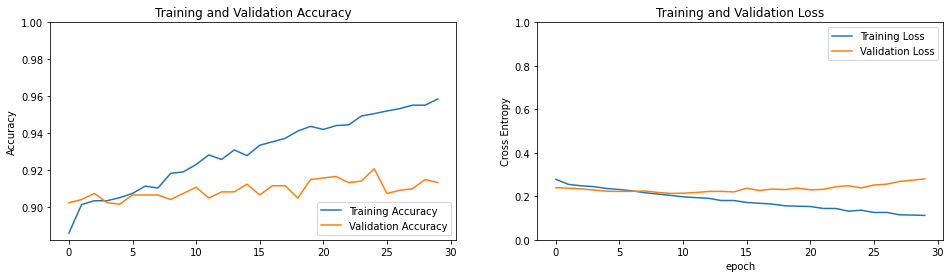

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Courbe apprentissage meilleur model (Logistic Regression)

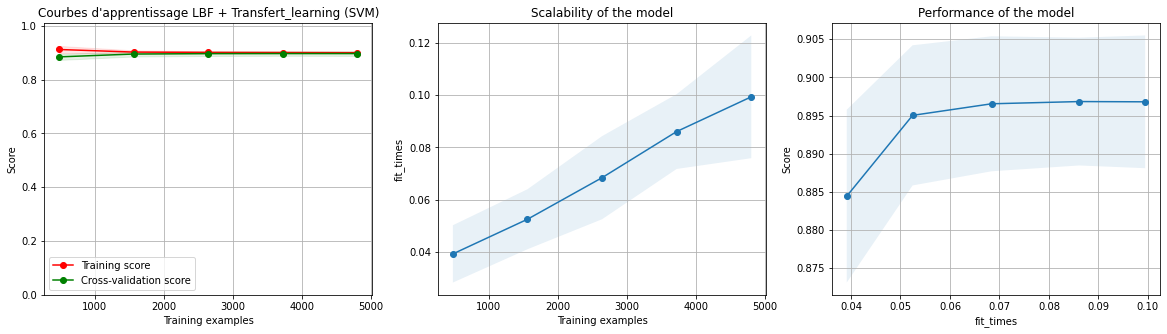

In [ ]:
best_model = model_lr

title = "Courbes d'apprentissage LBF + Transfert_learning (SVM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(best_model, title, X_train_pca, y_train, axes=None, ylim=(0.0, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

# Test

In [ ]:
predire = {0: "Live", 1: "Spoof"}

In [ ]:
from skimage import io
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import Model
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/anti_spoofing/feature_extraction.h5')
layer_name = 'dense_6'
intermediate_layer_model = Model(inputs=model_loaded.input, outputs=model_loaded.get_layer(layer_name).output)

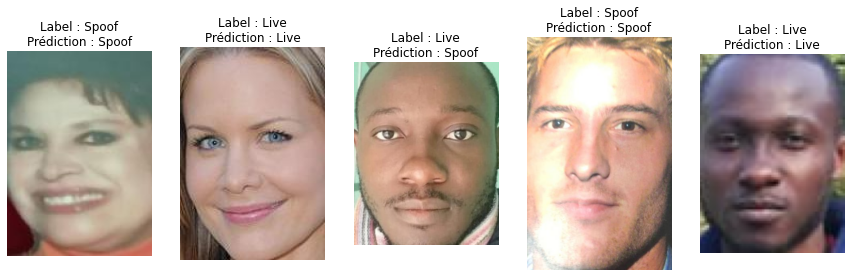

In [ ]:
image_path_0 = '/content/drive/MyDrive/Dataset/anti_spoofing/images/0.jpg'
image_path_1 = '/content/drive/MyDrive/Dataset/anti_spoofing/images/1.jpg'
image_path_2 = '/content/drive/MyDrive/Dataset/anti_spoofing/images/2.jpg'
image_path_3 = '/content/drive/MyDrive/Dataset/anti_spoofing/images/3.jpg'
image_path_4 = '/content/drive/MyDrive/Dataset/anti_spoofing/images/4.png'

liste_label = [1, 0, 0, 1, 0]

# Lecture des images
images = [cv.imread(image_path) for image_path in [image_path_0, image_path_1, image_path_2, image_path_3, image_path_4]]

# Extraction de caractéristiques de tensorflow
def extract_tf_test(im):
  img = tf.image.resize(im, [224, 224], method='nearest')
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  images = images / 255
  feature_tensorflow = intermediate_layer_model.predict([images])[0]
  return feature_tensorflow

features_tf = [extract_tf_test(im) for im in images]


images_test_ = pca.transform(features_tf)

plt.figure(figsize=(15, 10))
for i, im in enumerate(images_test_):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.title('Label : {}'.format(predire[liste_label[i]]) + '\nPrédiction : {}'.format(predire[best_model.predict(images_test_)[i]]))
    plt.axis("off")

plt.show()